### demonstrating clustering

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections

from util_transaction_data import *

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)


In [62]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)

#baskets = baskets[baskets.merchant_id !=191] # this is a system account
#baskets = baskets[baskets.merchant_id !=11] # this is a system account
#baskets = baskets[baskets.top_cat !=27] # remove cgarette top categories
#baskets = baskets[baskets.sub_cat !=86] # remove cigarette sub categories

baskets.dropna(inplace=True) # some rows had NA in top_cat and sub_cat

cat_mapping_file = './top_category_mapping_new.csv'
top_cat_names = pd.read_csv(cat_mapping_file)
df = baskets.merge(top_cat_names[["top_cat_id","top_cat_en"]], left_on="top_cat",right_on="top_cat_id")
baskets = df.drop(axis=1, columns=["top_cat_id"])

In [63]:
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

In [64]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

In [65]:
merchant_attributes.head()

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
0,1,11802400.0,11,13,21,4,6,8,52,12,19,1.072945e+06,9
1,2,15663100.0,13,12,24,6,10,11,52,13,21,1.204854e+06,13
2,3,38055700.0,37,11,16,6,13,26,145,24,43,1.028532e+06,6
3,4,1021000.0,2,19,20,2,2,2,9,5,5,5.105000e+05,2
4,5,2688000.0,2,13,18,2,2,2,20,7,9,1.344000e+06,6


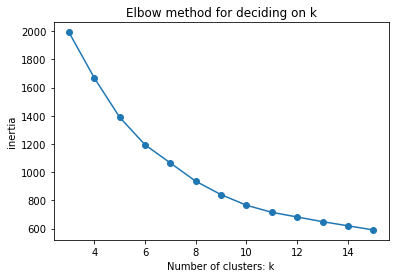

In [66]:
df = merchant_attributes
colnames = merchant_attributes.columns[1:] # do not use merchant_id in clustering
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

#kmeans.cluster_centers_

In [67]:
df = merchant_attributes
colnames = merchant_attributes.columns[1:]
k = 7
merchant_attributes_kmeans = run_kmeans(df, colnames,k,)
merchant_attributes_kmeans.groupby("cluster").size()


cluster
0     66
1     57
2    111
3      1
4     13
5     50
6     59
dtype: int64

In [87]:
merchant_attributes_kmeans[merchant_attributes_kmeans["cluster"]==4]

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month,cluster
12,13,5.926902e+08,88,6,24,13,23,56,316,27,54,6.735116e+06,19,4
14,15,2.293457e+09,318,6,24,17,51,299,508,30,74,7.212129e+06,19,4
15,16,2.677567e+09,239,6,24,17,48,212,545,30,71,1.120321e+07,19,4
19,20,1.528527e+09,224,6,24,18,44,204,464,29,63,6.823782e+06,19,4
51,52,2.260914e+09,399,9,24,16,53,351,637,32,78,5.666452e+06,16,4
65,66,7.153408e+08,124,9,24,16,46,119,585,30,82,5.768877e+06,16,4
103,104,8.559040e+08,71,10,16,7,22,69,279,23,51,1.205499e+07,7,4
121,122,1.048963e+09,124,10,24,15,45,119,248,23,49,8.459382e+06,15,4
127,128,1.563227e+09,291,10,24,15,47,265,603,30,82,5.371913e+06,15,4
160,161,1.420994e+09,78,10,24,15,44,73,176,24,45,1.821787e+07,15,4


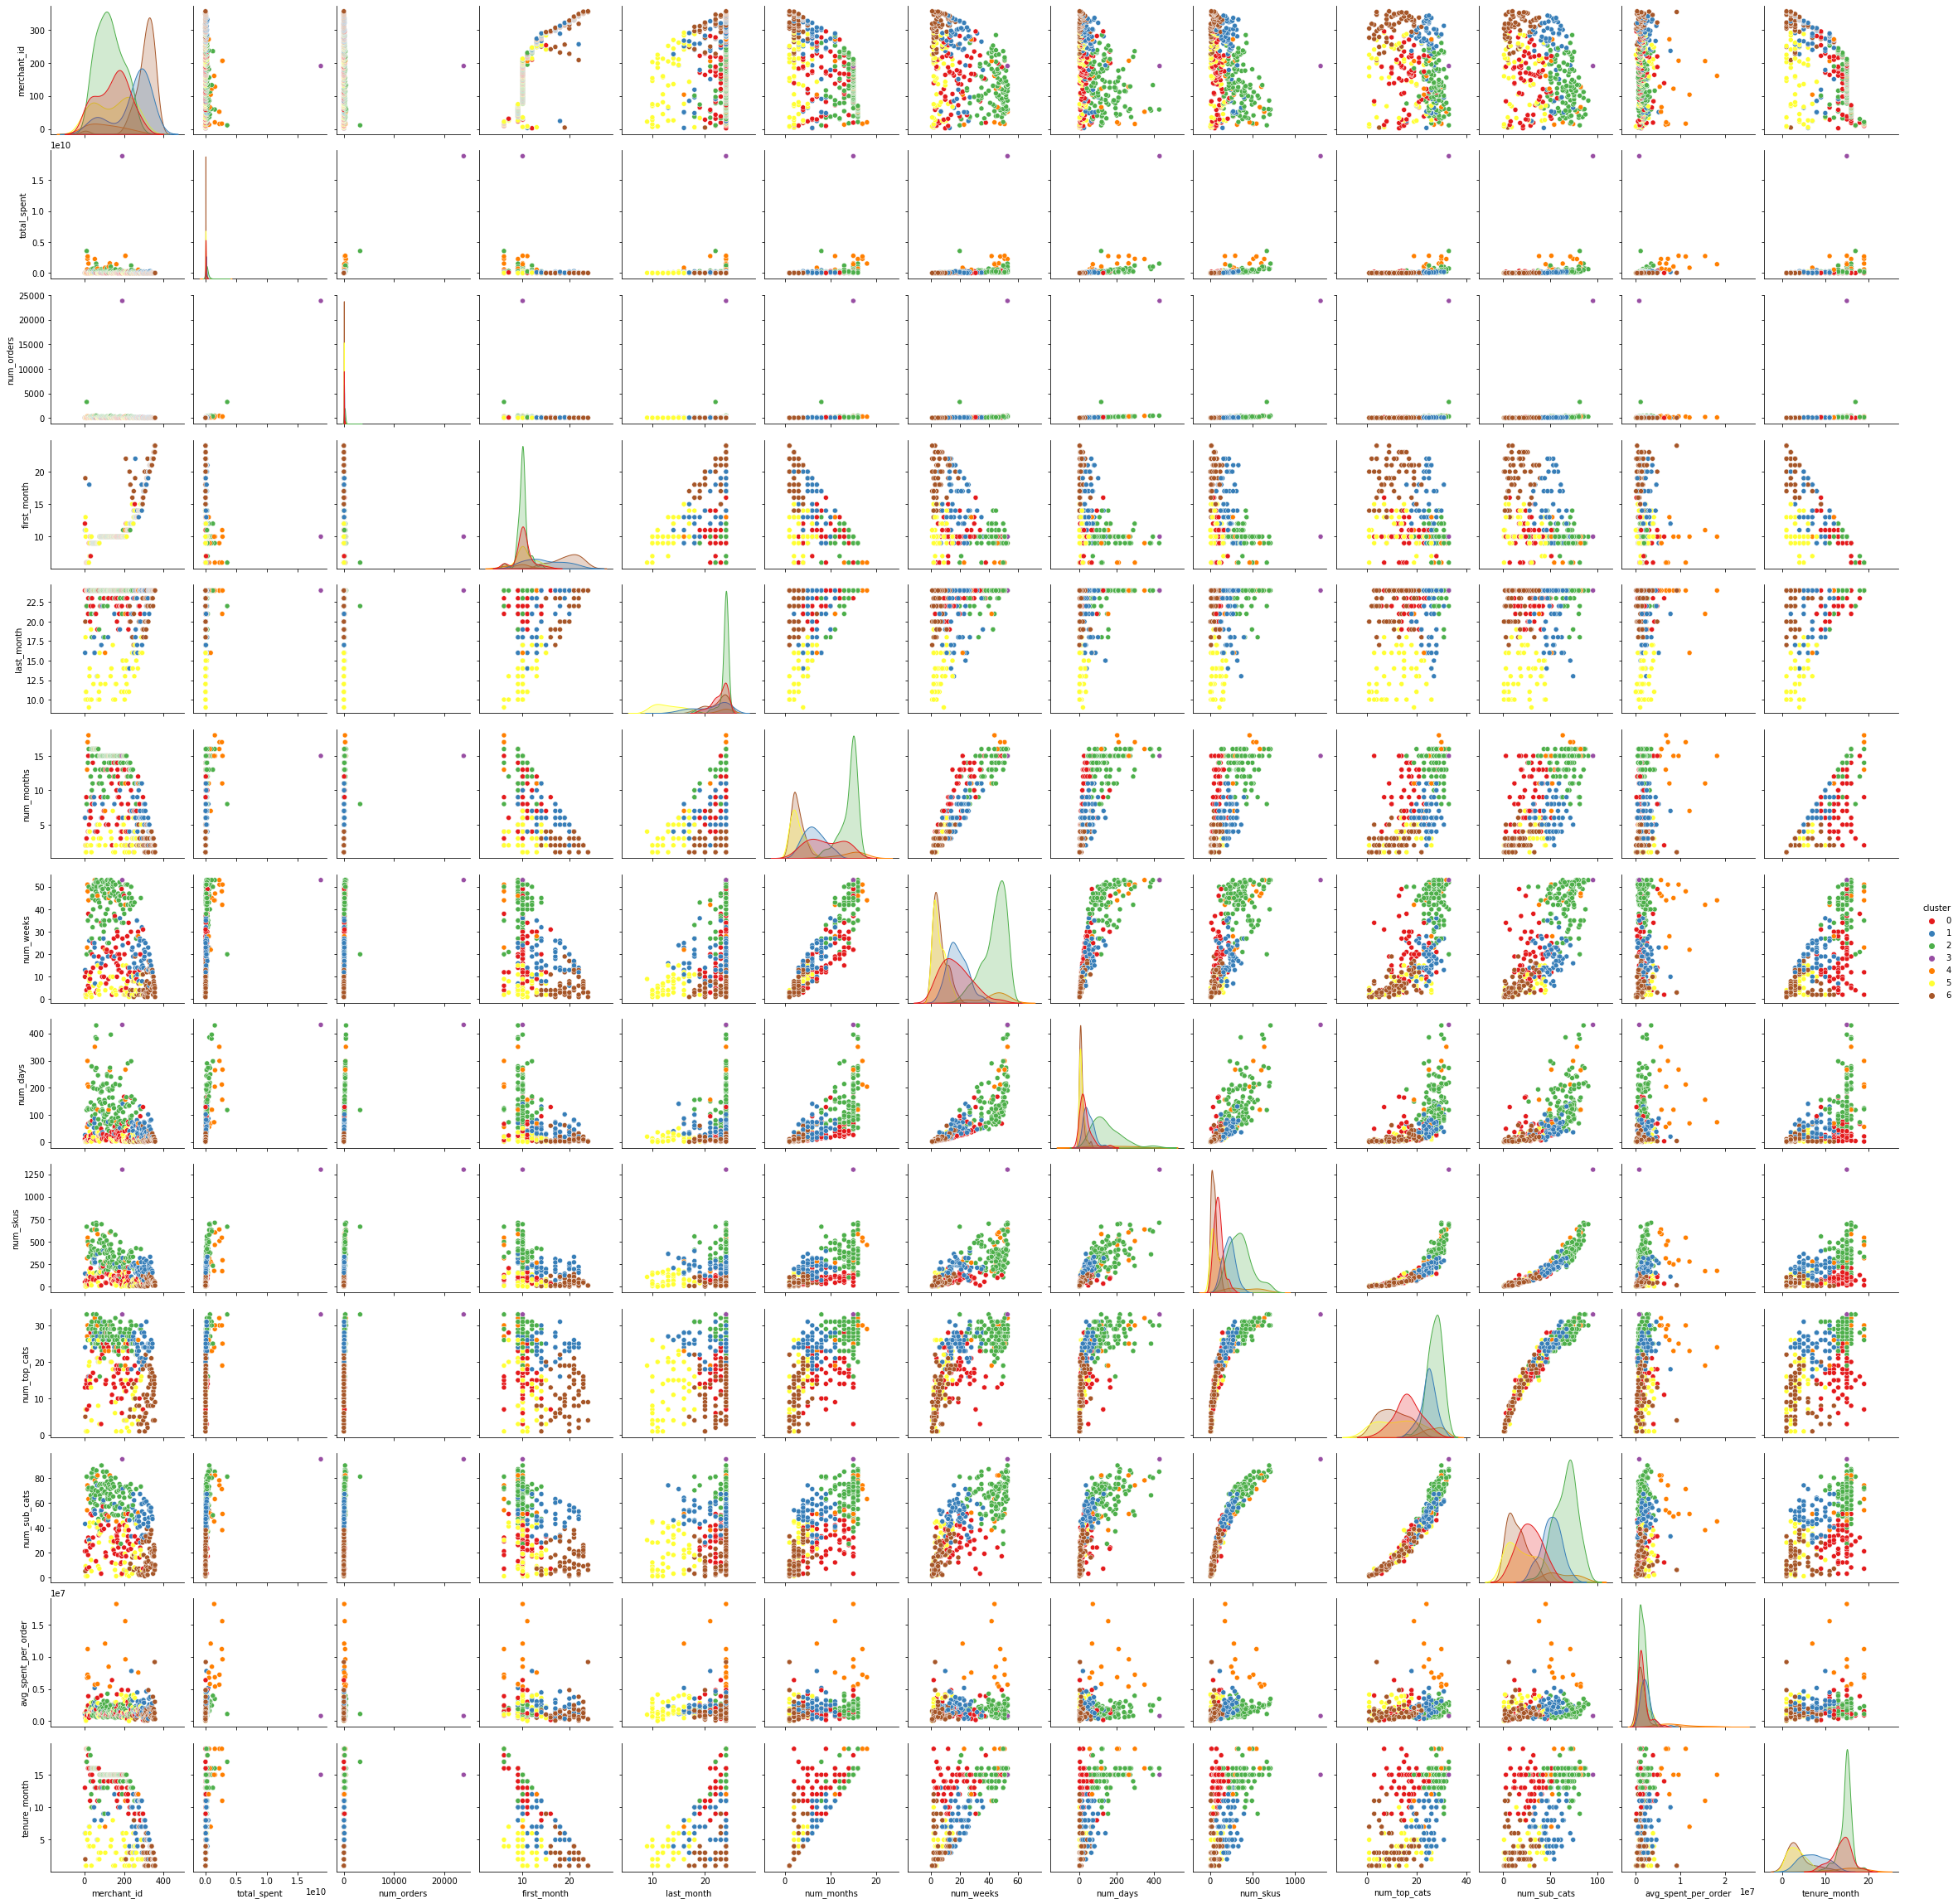

In [69]:
sns.pairplot(data=merchant_attributes_kmeans[1:], hue="cluster", palette="Set1")


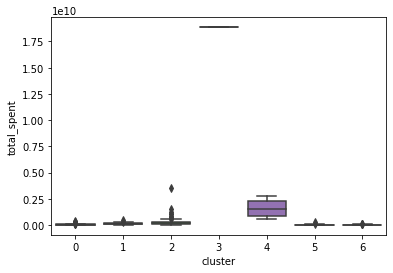

In [70]:
ax = sns.boxplot(x="cluster", y="total_spent", data=merchant_attributes_kmeans)

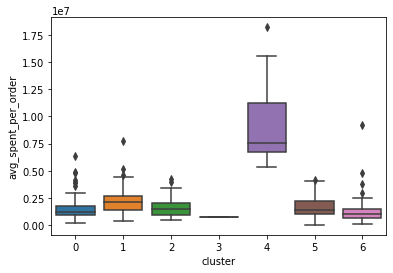

In [71]:
ax = sns.boxplot(x="cluster", y="avg_spent_per_order", data=merchant_attributes_kmeans)

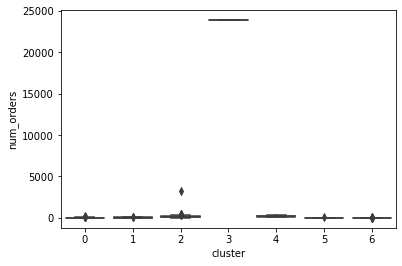

In [72]:
ax = sns.boxplot(x="cluster", y="num_orders", data=merchant_attributes_kmeans)

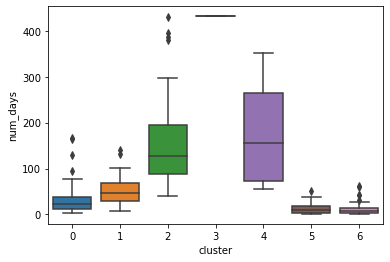

In [73]:
ax = sns.boxplot(x="cluster", y="num_days", data=merchant_attributes_kmeans)

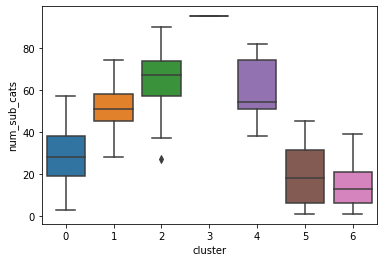

In [74]:
ax = sns.boxplot(x="cluster", y="num_sub_cats", data=merchant_attributes_kmeans)

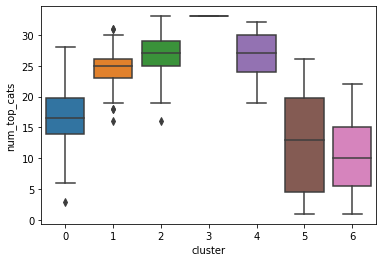

In [75]:
ax = sns.boxplot(x="cluster", y="num_top_cats", data=merchant_attributes_kmeans)

In [76]:
merchant_attributes_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   merchant_id          357 non-null    int64  
 1   total_spent          357 non-null    float64
 2   num_orders           357 non-null    int64  
 3   first_month          357 non-null    int64  
 4   last_month           357 non-null    int64  
 5   num_months           357 non-null    int64  
 6   num_weeks            357 non-null    int64  
 7   num_days             357 non-null    int64  
 8   num_skus             357 non-null    int64  
 9   num_top_cats         357 non-null    int64  
 10  num_sub_cats         357 non-null    int64  
 11  avg_spent_per_order  357 non-null    float64
 12  tenure_month         357 non-null    int64  
 13  cluster              357 non-null    int32  
dtypes: float64(2), int32(1), int64(11)
memory usage: 37.8 KB


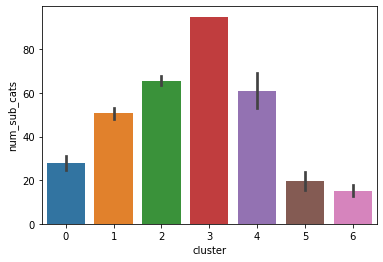

In [77]:
ax = sns.barplot(x="cluster", y="num_sub_cats", data=merchant_attributes_kmeans)

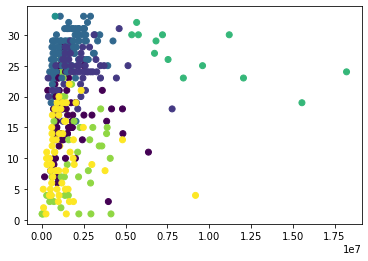

In [78]:
plt.scatter(merchant_attributes["avg_spent_per_order"], merchant_attributes["num_top_cats"],c=merchant_attributes.cluster)
plt.show()

<AxesSubplot:>

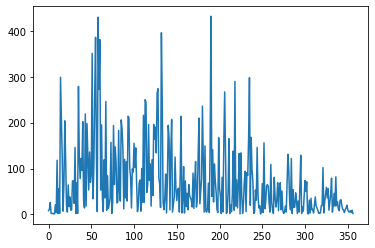

In [79]:
merchant_attributes.num_days.plot()

<AxesSubplot:>

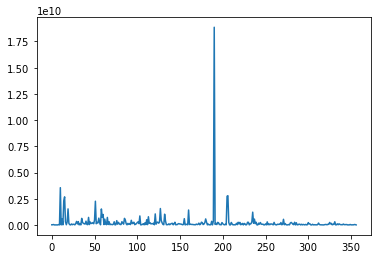

In [80]:
merchant_attributes.total_spent.plot()

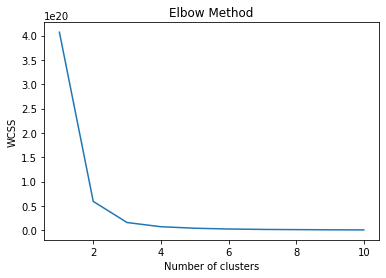

In [81]:
merchant_attributes_data = merchant_attributes[1:]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(merchant_attributes_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

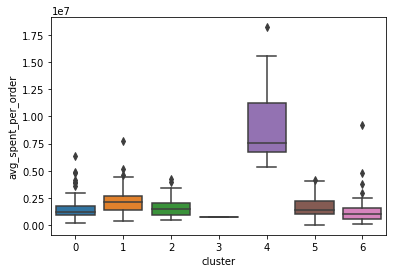

In [82]:
ax = sns.boxplot(x="cluster", y="avg_spent_per_order", data=merchant_attributes_data)

### cluster 5 looks like containing merchant_attributes who have high average spending per orders.

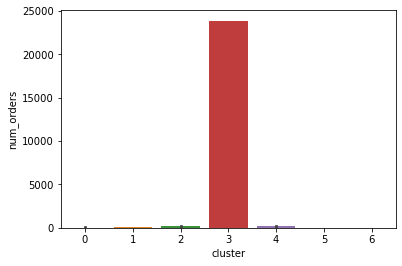

In [83]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchant_attributes_data)

<Figure size 1080x720 with 0 Axes>

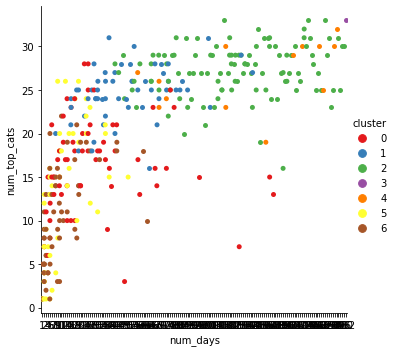

In [84]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_top_cats",data=merchant_attributes_data, hue="cluster", palette="Set1",ci="sd")

<Figure size 1080x720 with 0 Axes>

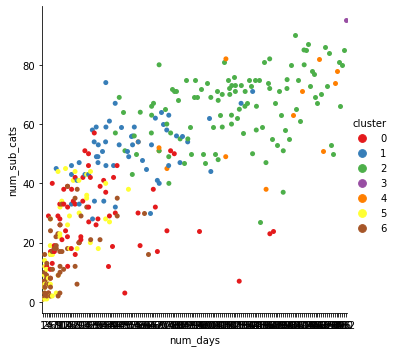

In [85]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_sub_cats",data=merchant_attributes_data, hue="cluster", palette="Set1",ci="sd")

<Figure size 1080x720 with 0 Axes>

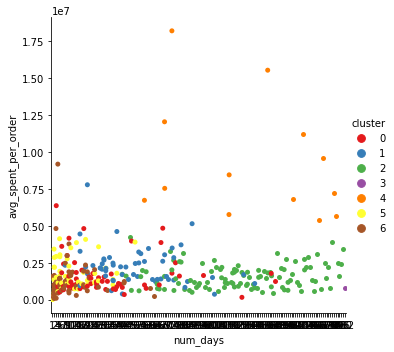

In [86]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(y="avg_spent_per_order", x = "num_days",data=merchant_attributes_data, hue="cluster", palette="Set1",ci="sd")